# Cost Estimation Model

## Libraries

In [1]:
pip install fastexcel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.1 MB/s eta 0:00:00


In [2]:
pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 6.7 MB/s eta 0:00:00


In [3]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.5 MB/s eta 0:00:00


Side note: It will be useful to put all the required libraries in a requirements.txt file

In [4]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Global variables

In [5]:
# Input paths
PATH_DATAFRAME = 'full_join.xlsx'

## Global functions

### 1. Read excel files with Polars

In [6]:
def polars_read_excel(file_name, sheet_name='Sheet1'):
  return pl.read_excel(source=file_name, sheet_name=sheet_name)

## Model development

### 1. File reading

In [7]:
df = polars_read_excel(PATH_DATAFRAME)

### 2. Column type

In [8]:
df = df.with_columns([
    pl.col("CostImpact (€)").cast(pl.Float64, strict=False),
])

### 3. Data selection

In [11]:
df_input = (
    df
    .filter(pl.col("IncidentID_AutoGen").is_not_null())
    .filter(pl.col("PackagingQuality").is_in(["Bad", "Good"]))
    .sort("DateOfReport")
    .select([
        "SupplierName",
        "GarmentType",
        "Material",
        "Weight",
        "ProposedUnitsPerCarton",
        "ProposedFoldingMethod",
        "ProposedLayout",
        "Size",
        "Collection",
        "PackagingQuality",
        "IssueDescription",
        "CostImpact (€)"
    ])
)

### 4. Categorical boosting

#### 4.1 Training

In [13]:
# Convert Polars to Pandas
df_pd = df_input.to_pandas()

# Define features and target
X = df_pd.drop(columns=["CostImpact (€)"])
y = df_pd["CostImpact (€)"]

# Identify categorical columns
categorical_features = X.select_dtypes(include="object").columns.tolist()

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Create CatBoost Pools
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

# Train CatBoost Regressor
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function="RMSE",
    early_stopping_rounds=50,
    random_seed=42,
    verbose=100
)

model.fit(train_pool, eval_set=test_pool)

0:	learn: 476.0206072	test: 477.5901001	best: 477.5901001 (0)	total: 65.6ms	remaining: 1m 5s
100:	learn: 248.0184726	test: 251.3549861	best: 251.3306818 (97)	total: 1.56s	remaining: 13.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 251.3306818
bestIteration = 97

Shrink model to first 98 iterations.


#### 4.2 Evaluating

In [22]:
# Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 179.92
RMSE: 251.33
R² Score: 0.74


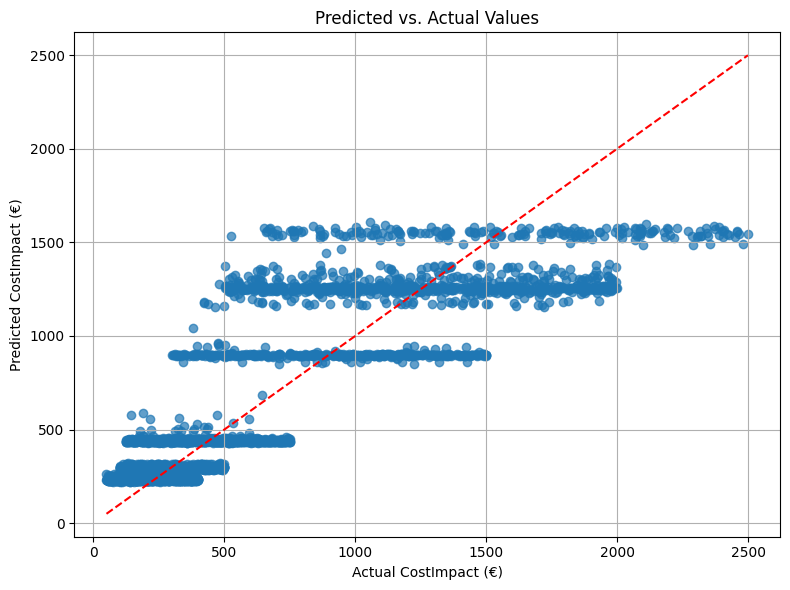

In [17]:
# Comparison plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual CostImpact (€)")
plt.ylabel("Predicted CostImpact (€)")
plt.title("Predicted vs. Actual Values")
plt.grid(True)
plt.tight_layout()
plt.show()

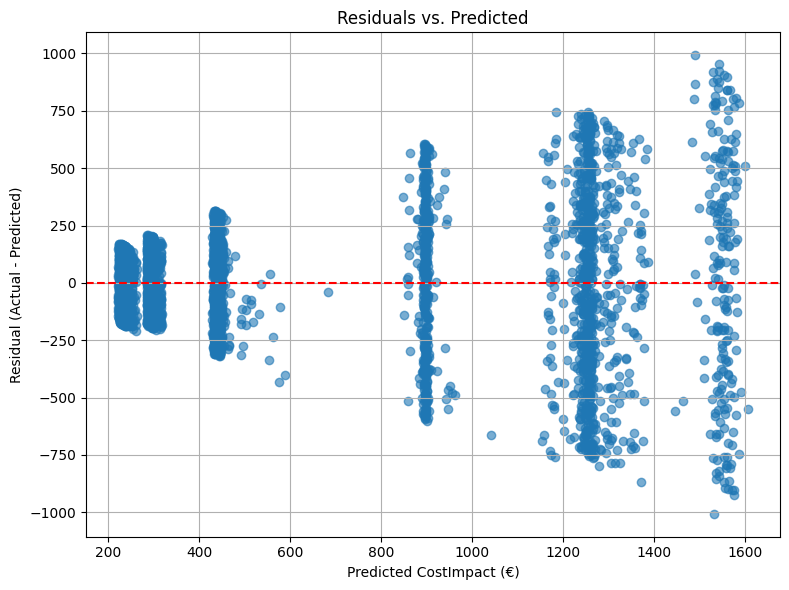

In [18]:
# Residual plot
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted CostImpact (€)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs. Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

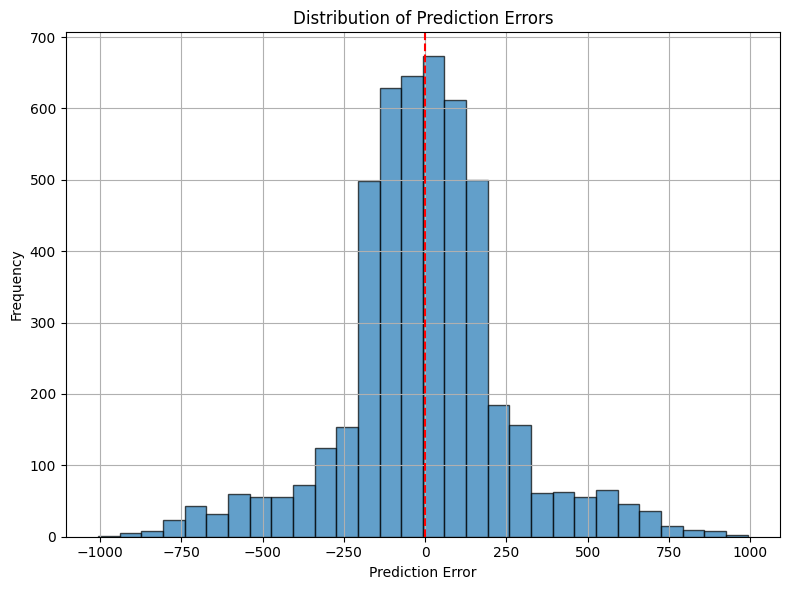

In [19]:
# Error distribution histogram
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Get the feature importance
feature_importance = model.get_feature_importance(prettified=True)
print(feature_importance)

                Feature Id  Importances
0         IssueDescription    81.495074
1    ProposedFoldingMethod     6.371575
2                   Weight     4.222589
3   ProposedUnitsPerCarton     3.497402
4                 Material     2.128923
5           ProposedLayout     1.023099
6              GarmentType     0.399229
7         PackagingQuality     0.302229
8             SupplierName     0.235326
9                     Size     0.168086
10              Collection     0.156469


#### 4.3 Saving

In [ ]:
# Saving the model
model.save_model("catboost_model.cbm")

# Reading the model
# model = CatBoostClassifier()
# model.load_model("catboost_model.cbm")